In [1]:
import abtem
import matplotlib.pyplot as plt
import numpy as np
from ase.build import graphene
from gpaw import GPAW

abtem.config.set({'local_diagnostics.progress_bar': False});

# *ab initio* potentials with GPAW

The independent atom model (IAM) neglects any effects due to bonding and charge transfer, this is typically a good approximation, because the core charge and electrons are responible for most of the potential. However, the difference between the IAM and a more realistic model including the effects of bonding is measurable, at least in certain systems. This difference is important, due to the importance of charge transfer in chemistry. 

Here we go beyond the independent atom model using density functional theory (DFT), to calculate a potential that includes charge transfer. Note that you need a working GPAW installation, see the [GPAW documentation](https://wiki.fysik.dtu.dk/gpaw/) for more information.

*abTEM* supports and recommends GPAW, however, other codes may be used assuming you can obtain the electron charge density as a numpy array. 

## DFT calculation of hBN with GPAW
The first step to creating a DFT potential is to converge a DFT calculation. We claculate the minimal hexagonal cell of hexagonal-Boron-Nitride (hBN). The atomic model is created by modifying a graphene model.

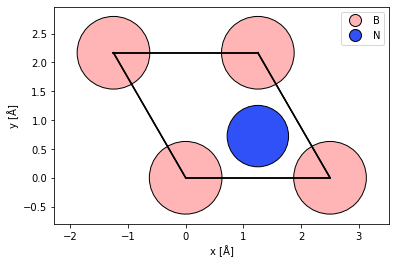

In [2]:
atoms = graphene(vacuum=3, a=2.504)

atoms[0].number = 5
atoms[1].number = 7

abtem.show_atoms(atoms, legend=True, show_periodic=True);

To run the DFT calculation, we use the `GPAW` calculator. We use the default parameters, except for the k-points which have to be at least `(5,5,1)` for a cell of this tiny size. 

Running the method `get_potential_energy` triggers the DFT self-consistent field cycle to run, after which the `GPAW` object contains the converged PAW electron density.

In [3]:
gpaw = GPAW(txt=None, kpts=(5, 5, 1))
atoms.calc = gpaw
atoms.get_potential_energy()

-19.369576502082047

## Importing/exporting GPAW calculations

DFT calculations for image simulations can be extremely computationally intensive, and may require massive parallelization. Hence, your workflow will often require exporting the DFT calculation to a file, then importing it for your *abTEM* iam simulation. Exporting and importing from `GPAW` works as demonstrated below.

In [4]:
gpaw.write("hbn.gpw")

gpaw = GPAW("hbn.gpw", txt=None)

## Using the GPAW potential in abTEM

It is straightforward to calculate a DFT potential from a converged GPAW calculation. The `GPAWPotential` object just requires a converged GPAW calculator.

In [5]:
potential_dft = abtem.GPAWPotential(gpaw, sampling=0.05).build()

The `GPAWPotential` shares the same supertype as the standard potential, hence, they share most of their properties and methods.

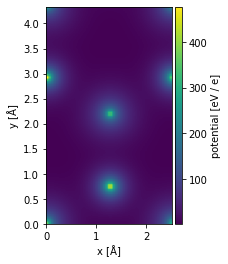

In [6]:
potential_dft.show(cbar=True);

## Comparing DFT to IAM

To show the difference that including charge trasnfer can have, we compare the DFT potential to an equivalent potential using the IAM. We make sure to set `projection="finite"` to ensure that the projection integrals are done identically.

In [7]:
atoms = gpaw.atoms

potential_iam = abtem.Potential(
    atoms, gpts=potential_dft.gpts, projection="finite"
).build()

Note that the zero level of the potential is set to 0 for both the IAM and DFT potentials to facilitate comparison. This makes their calculated relative difference diverge near the atom cores, which is here accounted for by setting diverging values to `nan` and coloring them with grey.

To compare the potentials we convert them to `Images` by projecting them. 




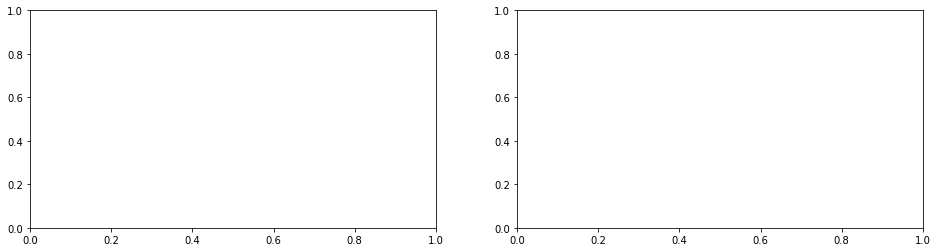

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))


In [9]:
a = potential_iam.project().array.compute()
b= potential_dft.project().array.compute()
b = b- b.min()
a = a- a.min()


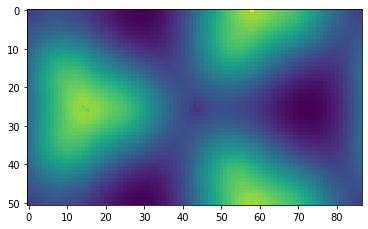

In [10]:
plt.imshow(a-b)

/opt/anaconda3/envs/abtem-dask/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


(<Figure size 432x288 with 2 Axes>, <Axes:xlabel='x [Å]', ylabel='y [Å]'>)

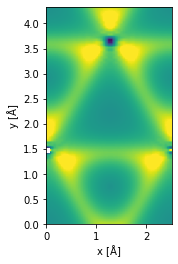

In [12]:
difference = potential_iam.project() - potential_dft.project()
#relative_difference = (potential_iam.project() - potential_dft.project()) / potential_iam.project()

iam_projected = potential_iam.project()
iam_projected = iam_projected - iam_projected.min()

dft_projected = difference = potential_dft.project() 
dft_projected = dft_projected - dft_projected.min()

((iam_projected-dft_projected) / dft_projected).show(vmin=-1, vmax=1)
#(difference / potential_iam.project()).show(vmin=-.5, vmax=.5)
#relative_difference.show(vmin=-.5, vmax=.5)
#relative_difference.show(vmin=.01, vmax=.01)
#fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

#().show(cmap='bwr', cbar=True, vmin=-14, vmax=14);

In [91]:
(difference / potential_iam.project()).array.compute().max()

0.33360052

In [64]:
relative_difference.max().compute()

14.070984

In [29]:
potential_iam.project().re

-------------------------------------------------------

type           label    coordinates
-------------  -------  ------------------
RealSpaceAxis  x [Å]    0.00 0.05 ... 2.45
RealSpaceAxis  y [Å]    0.00 0.05 ... 4.29

        bytes      shape     count     type
------  ---------  --------  --------  -------------
array   17.33 kiB  (51, 87)  6 tasks   float32
chunks  17.33 kiB  (51, 87)  1 chunks  numpy.ndarray

In [19]:
projected_iam = potential_iam.build().compute()
projected_iam -= projected_iam.min()

#projected_dft = potential_dft.array.sum(0)
#projected_dft -= projected_dft.min()

#absolute_difference = projected_iam - projected_dft

AttributeError: 'numpy.float32' object has no attribute 'is_lazy'

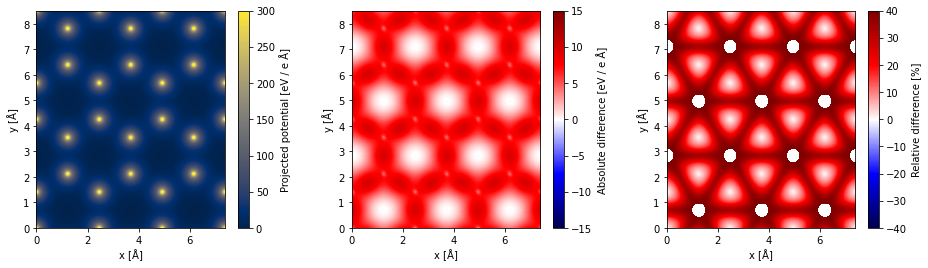

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

extent = [0, dft_potential.extent[0], 0, dft_potential.extent[1]]

im1 = ax1.imshow(projected_dft.T, cmap="cividis", vmax=300, extent=extent)
im2 = ax2.imshow(
    absolute_difference.T, vmin=-15, vmax=15, cmap="seismic", extent=extent
)
im3 = ax3.imshow(
    relative_difference.T, vmin=-40, vmax=40, cmap="seismic", extent=extent
)

labels = (
    "Projected potential [eV / e Å]",
    "Absolute difference [eV / e Å]",
    "Relative difference [%]",
)

for ax, im, label in zip((ax1, ax2, ax3), (im1, im2, im3), labels):
    ax.set_xlabel("x [Å]")
    ax.set_ylabel("y [Å]")

    fig.colorbar(im, ax=ax, label=label)